# Customer Churn Prediction using Machine Learning

DQLab Telco merupakan perusahaan Telco yang sudah mempunyai banyak cabang tersebar dimana-mana. Sejak berdiri pada tahun 2019, DQLab Telco konsisten untuk memperhatikan customer experience nya sehingga tidak akan di tinggalkan pelanggan.

Walaupun baru berumur 1 tahun lebih sedikit, DQLab Telco sudah mempunyai banyak pelanggan yang beralih langganan ke kompetitior. Pihak management ingin mengurangi jumlah pelanggan yang beralih (churn) dengan menggunakan machine learning.

### 1. Exploratory Data Analysis

In [25]:
#Import library yang dibutuhkan 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from pathlib import Path

import warnings

warnings.filterwarnings('ignore')

In [26]:
#import dataset yang digunakan
df_load = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/dqlab_telco_final.csv')

#### File Unloading

In [27]:
#Tampilkan bentuk dari dataset
print(df_load.shape)

#Tampilkan 5 data teratas
print(df_load.head())

(6950, 13)
   UpdatedAt   customerID  gender SeniorCitizen Partner  tenure PhoneService  \
0     202006  45759018157  Female            No     Yes       1           No   
1     202006  45315483266    Male            No     Yes      60          Yes   
2     202006  45236961615    Male            No      No       5          Yes   
3     202006  45929827382  Female            No     Yes      72          Yes   
4     202006  45305082233  Female            No     Yes      56          Yes   

  StreamingTV InternetService PaperlessBilling  MonthlyCharges  TotalCharges  \
0          No             Yes              Yes           29.85         29.85   
1          No              No              Yes           20.50       1198.80   
2         Yes             Yes               No          104.10        541.90   
3         Yes             Yes              Yes          115.50       8312.75   
4         Yes             Yes               No           81.25       4620.40   

  Churn  
0    No  
1    No

#### Yang akan dilihat pada EDA ini adalah:
1. Prosentase persebaran data Churn dan tidaknya dari seluruh data
2. Persebaran data dari variable predictor terhadap label (Churn)

### 1. Memvisualisasikan Prosentase Churn

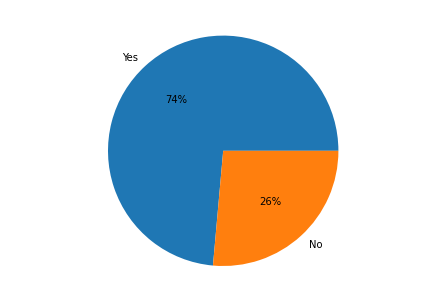

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['Yes','No']
churn = df_load.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.show()

### 2. Exploratory Data Analysis (EDA) Variabel Numerik

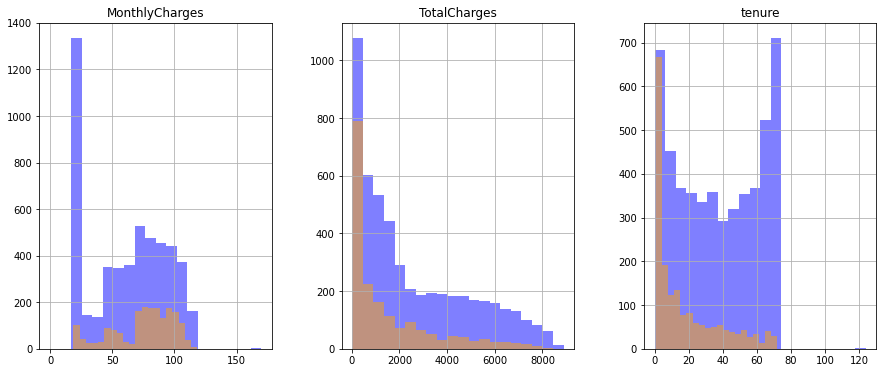

In [29]:
#creating bin in chart
numerical_features =  ['MonthlyCharges','TotalCharges','tenure']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
# Use the following code to plot two overlays of histogram per each numerical_features, use a color of blue and orange, respectively
df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

### 3. Exploratory Data Analysis (EDA) Variabel Kategorik

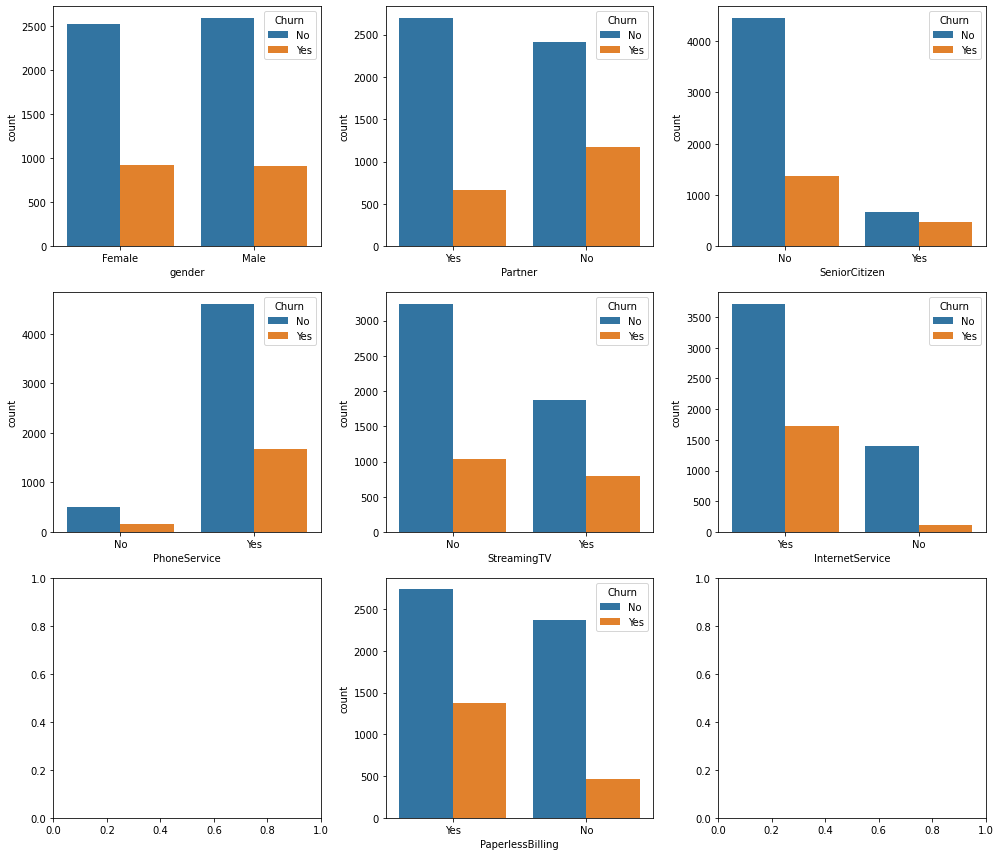

In [30]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

### Kesimpulan
1. Pada tahap C.1 dapat kita ketahui bahwa sebaran data secara kesuluruhan customer tidak melakukan churn, dengan detil Churn sebanyak 26% dan No Churn sebanyak 74%.
2. Pada tahap C.2 dapat kita ketahui bahwa untuk MonthlyCharges ada kecenderungan semakin kecil nilai biaya bulanan yang dikenakan, semakin kecil juga kecenderungan untuk melakukan Churn. Untuk TotalCharges terlihat tidak ada kecenderungan apapun terhadap Churn customers. Untuk tenure ada kecenderungan semakin lama berlangganan customer, semakin kecil kecenderungan untuk melakukan Churn.
3. Pada tahap C.3 dapat kita ketahui bahwa tidak ada perbedaan yang signifikan untuk orang melakukan churn dilihat dari faktor jenis kelamin (gender) dan layanan telfonnya (PhoneService). Akan tetapi ada kecenderungan bahwa orang yang melakukan churn adalah orang-orang yang tidak memiliki partner (partner: No), orang-orang yang statusnya adalah senior citizen(SeniorCitizen: Yes), orang-orang yang mempunyai layanan streaming TV (StreamingTV: Yes), orang-orang yang mempunyai layanan Internet (internetService: Yes) dan orang-orang yang tagihannya paperless (PaperlessBilling: Yes).

### 2. Data Preprocessing

#### Menghapus Unnecessary Columns dari data

In [31]:
#Remove the unnecessary columns customerID & UpdatedAt
cleaned_df = df_load.drop(['customerID', 'UpdatedAt'],axis=1)
print(cleaned_df.head())

   gender SeniorCitizen Partner  tenure PhoneService StreamingTV  \
0  Female            No     Yes       1           No          No   
1    Male            No     Yes      60          Yes          No   
2    Male            No      No       5          Yes         Yes   
3  Female            No     Yes      72          Yes         Yes   
4  Female            No     Yes      56          Yes         Yes   

  InternetService PaperlessBilling  MonthlyCharges  TotalCharges Churn  
0             Yes              Yes           29.85         29.85    No  
1              No              Yes           20.50       1198.80    No  
2             Yes               No          104.10        541.90   Yes  
3             Yes              Yes          115.50       8312.75    No  
4             Yes               No           81.25       4620.40    No  


#### Encoding Data

In [32]:
from sklearn.preprocessing import LabelEncoder
#Convert all the non-numeric columns to numerical data types
for column in cleaned_df.columns:
	if cleaned_df[column].dtype == np.number: continue
    # Perform encoding for each non-numeric column
cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            tenure  MonthlyCharges  TotalCharges        Churn
count  6950.000000     6950.000000   6950.000000  6950.000000
mean     32.423165       64.992201   2286.058750     0.264173
std      24.581073       30.032040   2265.702553     0.440923
min       0.000000        0.000000     19.000000     0.000000
25%       9.000000       36.462500    406.975000     0.000000
50%      29.000000       70.450000   1400.850000     0.000000
75%      55.000000       89.850000   3799.837500     1.000000
max     124.000000      169.931250   8889.131250     1.000000


#### Splitting Dataset

In [33]:
# Predictor dan target
X = cleaned_df.drop('Churn', axis = 1)
y = cleaned_df['Churn']

In [34]:
# Splitting train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print according to the expected result
print('Jumlah baris dan kolom dari x_train adalah:', x_train.shape,', sedangkan Jumlah baris dan kolom dari y_train adalah:', y_train.shape)
print('Prosentase Churn di data Training adalah:')
print(y_train.value_counts(normalize=True))
print('Jumlah baris dan kolom dari x_test adalah:', x_test.shape,', sedangkan Jumlah baris dan kolom dari y_test adalah:', y_test.shape)
print('Prosentase Churn di data Testing adalah:')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah: (4865, 10) , sedangkan Jumlah baris dan kolom dari y_train adalah: (4865,)
Prosentase Churn di data Training adalah:
0    0.734841
1    0.265159
Name: Churn, dtype: float64
Jumlah baris dan kolom dari x_test adalah: (2085, 10) , sedangkan Jumlah baris dan kolom dari y_test adalah: (2085,)
Prosentase Churn di data Testing adalah:
0    0.738129
1    0.261871
Name: Churn, dtype: float64


#### Kesimpulan
- ada kolom yang tidak dibutuhkan dalam model, yaitu customerID & UpdatedAt
- ubah value dari data yang masih berbentuk string menjadi numeric melalui encoding, setelah dilakukan terlihat di persebaran datanya khususnya kolom min dan max dari masing masing variable sudah berubah menjadi 0 & 1.
- tahap terakhir adalah membagi data menjadi 2 bagian untuk keperluan modelling, setelah dilakukan terlihat dari jumlah baris dan kolom masing-masing data sudah sesuai & prosentase kolom churn juga sama dengan data di awal, hal ini mengindikasikan bahwasannya data terpisah dengan baik dan benar.

### Modelling: Logistic Regression

#### Pembuatan Model

In [40]:
log_model = LogisticRegression().fit(x_train,y_train)
print('Model Logistic Regression yang terbentuk adalah: \n', log_model)

Model Logistic Regression yang terbentuk adalah: 
 LogisticRegression()


#### Performansi Model Training - Menampilkan Metrics

In [36]:
# Predict
y_train_pred = log_model.predict(x_train)
# Print classification report 
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3575
           1       0.65      0.49      0.56      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.70      0.72      4865
weighted avg       0.78      0.80      0.79      4865



#### Performansi Model Training - Menampilkan Plots

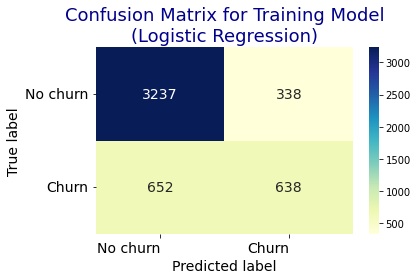

In [37]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

#### Performansi Data Testing - Menampilkan Metrics

In [38]:
# Predict
y_test_pred = log_model.predict(x_test)
# Print classification report 
print('Classification Report Testing Model (Logistic Regression) :')
print(classification_report(y_test,y_test_pred))

Classification Report Testing Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



#### Performansi Data Testing - Menampilkan Plots

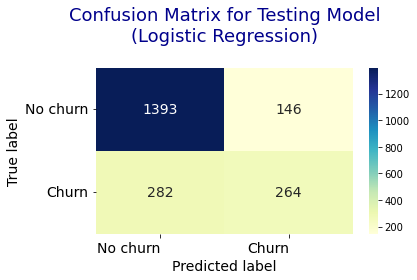

In [39]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

#### Kesimpulan
- Dari data training terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 80%, dengan detil tebakan churn yang sebenernya benar churn adalah 638, tebakan tidak churn yang sebenernya tidak churn adalah 3237, tebakan tidak churn yang sebenernya benar churn adalah 652 dan tebakan churn yang sebenernya tidak churn adalah 338.
- Dari data testing terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 79%, dengan detil tebakan churn yang sebenernya benar churn adalah 264, tebakan tidak churn yang sebenernya tidak churn adalah 1392, tebakan tidak churn yang sebenernya benar churn adalah 282 dan tebakan churn yang sebenernya tidak churn adalah 146.